In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
SPECIES_DATA = "../results/species_data.csv"
G4_PATH = "../results/g4hunter_g4_distribution.csv"
REG_PATH = "../results/regex_g4_distribution.csv"
VIRUS_DATA_PATH = "../metadata/virus_data.tsv"    

# set color map for domains
color_map = {
    'Virus': '#66c2a5',
    'Bacteria': '#fc8d62',
    'Eukaryota': '#8da0cb',
    'Archaea': '#e78ac3'
}

def get_domain(taxa):
    if taxa == 'viral':
        return 'Virus'
    elif taxa == 'bacteria':
        return 'Bacteria'
    elif taxa == 'archaea':
        return 'Archaea'
    else:
        return 'Eukaryota'   
    
def get_host_domain(host):
    host_domain = {
        "vertebrates": "Eukaryota",
        "invertebrates": "Eukaryota",
        "algae": "Eukaryota",
        "plants": "Eukaryota",
        "protozoa": "Eukaryota",
        "bacteria": "Bacteria",
        "land plants": "Eukaryota",
        "human": "Eukaryota",
        "eukaryotic algae": "Eukaryota",
        "archaea": "Archaea",
        "diatom": "Eukaryota",
        "fungi": "Eukaryota",
        "-" : "-"
    }
    hosts = host.split(",")
    domains = [host_domain[host] for host in hosts]
    unique_domains = list(set(domains))
    return ", ".join(unique_domains)

In [4]:
# species data
df_species = pd.read_csv(SPECIES_DATA)
df_species = df_species[["Accession", "Species", "Genome Size", "GC Percentage", "Taxa", "Kingdom", "Phylum"]]
df_species = df_species.replace('na', np.nan)
df_species["GC Percentage"] = df_species["GC Percentage"].astype(float)
df_species["Genome Size"] = df_species["Genome Size"].astype(float)
df_species["Domain"] = df_species["Taxa"].apply(get_domain)

# virus-host dictionary
df_virus_data = pd.read_csv(VIRUS_DATA_PATH, sep="\t")
df_virus_host_data = df_virus_data[['#Organism/Name', 'Host']]
virus_host_dict = df_virus_host_data.set_index('#Organism/Name').T.to_dict('list')
virus_host_dict = {k: [x.strip() for x in list(set(','.join(set(v)).split(',')))] for k, v in virus_host_dict.items()}
virus_host_dict = {k: ','.join(v) for k, v in virus_host_dict.items()}

/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_63430/4014061759.py:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  virus_host_dict = df_virus_host_data.set_index('#Organism/Name').T.to_dict('list')


In [5]:
# g4 data from g4hunter
df_g4 = pd.read_csv(G4_PATH)
df_g4 = df_g4[["accession", "g4_count", "total_g4_length"]]
df_g4 = df_g4.rename(columns={"accession": "Accession"})
df_g4["g4_count"] = df_g4["g4_count"].astype(float)
df_g4["total_g4_length"] = df_g4["total_g4_length"].astype(float)

# merge with species data
df_g4 = pd.merge(df_g4, df_species, on="Accession")
df_g4["G4 Density (per Mb)"] = df_g4["g4_count"] / df_g4["Genome Size"] * 1000000
df_g4["GC Corrected G4 Density (per Mb)"] = df_g4["G4 Density (per Mb)"] / (df_g4["GC Percentage"] / 50)

# filter out metagenomes and other taxa as they are not relevant for domain level analysis
df_g4 = df_g4[df_g4["Taxa"] != "metagenomes"]
df_g4 = df_g4[df_g4["Taxa"] != "other"]

# for viruses, set kingdom as virus
df_g4.loc[df_g4["Taxa"] == "viral", "Kingdom"] = "Virus"

# get host info for all viral species 
df_g4_virus = df_g4[df_g4["Kingdom"] == "Virus"]
df_g4_virus["Host"] = df_g4_virus["Species"].map(virus_host_dict)
df_g4_virus = df_g4_virus.dropna()
df_g4_virus["Host Domain"] = df_g4_virus["Host"].apply(get_host_domain)
df_g4_virus = df_g4_virus.explode("Host Domain")
df_g4_virus = df_g4_virus[df_g4_virus["Host Domain"] != "-"]
df_g4_virus["log10(G4 Density)"] = np.log10(df_g4_virus["G4 Density (per Mb)"]+1)
df_g4_virus = df_g4_virus[["Accession", "Phylum", "Host", "Host Domain", "G4 Density (per Mb)", "log10(G4 Density)"]]
df_g4_virus.head()

/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_63430/1783434632.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_g4_virus["Host"] = df_g4_virus["Species"].map(virus_host_dict)


,Accession,Phylum,Host,Host Domain,G4 Density (per Mb),log10(G4 Density)
1273,GCA_000820495.2,Negarnaviricota,"vertebrates,human",Eukaryota,0.000000,0.000000
1326,GCA_000836825.1,Cossaviricota,vertebrates,Eukaryota,212.901852,2.330215
1328,GCA_000836945.1,Uroviricota,bacteria,Bacteria,11.841116,1.108603
1329,GCA_000836965.1,Uroviricota,bacteria,Bacteria,98.157100,1.996324
1331,GCA_000837025.1,Preplasmiviricota,bacteria,Bacteria,334.963489,2.526292


In [6]:
# g4 data from regex
df_reg = pd.read_csv(REG_PATH)
df_reg = df_reg[["accession", "g4_count", "total_g4_length"]]
df_reg = df_reg.rename(columns={"accession": "Accession"})
df_reg["g4_count"] = df_reg["g4_count"].astype(float)
df_reg["total_g4_length"] = df_reg["total_g4_length"].astype(float)

# merge with species data
df_reg = pd.merge(df_reg, df_species, on="Accession")
df_reg["G4 Density (per Mb)"] = df_reg["g4_count"] / df_reg["Genome Size"] * 1000000
df_reg["GC Corrected G4 Density (per Mb)"] = df_reg["G4 Density (per Mb)"] / (df_reg["GC Percentage"] / 50)

# filter out metagenomes and other taxa as they are not relevant for domain level analysis
df_reg = df_reg[df_reg["Taxa"] != "metagenomes"]
df_reg = df_reg[df_reg["Taxa"] != "other"]

# for viruses, set kingdom as virus
df_reg.loc[df_reg["Taxa"] == "viral", "Kingdom"] = "Virus"

# get host info for all viral species 
df_reg_virus = df_reg[df_reg["Kingdom"] == "Virus"]
df_reg_virus["Host"] = df_reg_virus["Species"].map(virus_host_dict)
df_reg_virus = df_reg_virus.dropna()
df_reg_virus["Host Domain"] = df_reg_virus["Host"].apply(get_host_domain)
df_reg_virus = df_reg_virus.explode("Host Domain")
df_reg_virus = df_reg_virus[df_reg_virus["Host Domain"] != "-"]
df_reg_virus["log10(G4 Density)"] = np.log10(df_reg_virus["G4 Density (per Mb)"]+1)
df_reg_virus = df_reg_virus[["Accession", "Phylum", "Host", "Host Domain", "G4 Density (per Mb)", "log10(G4 Density)"]]
df_reg_virus.head()

/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_63430/1214932752.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg_virus["Host"] = df_reg_virus["Species"].map(virus_host_dict)


,Accession,Phylum,Host,Host Domain,G4 Density (per Mb),log10(G4 Density)
1273,GCA_000820495.2,Negarnaviricota,"vertebrates,human",Eukaryota,0.000000,0.000000
1326,GCA_000836825.1,Cossaviricota,vertebrates,Eukaryota,0.000000,0.000000
1328,GCA_000836945.1,Uroviricota,bacteria,Bacteria,0.000000,0.000000
1329,GCA_000836965.1,Uroviricota,bacteria,Bacteria,0.000000,0.000000
1331,GCA_000837025.1,Preplasmiviricota,bacteria,Bacteria,133.985396,2.130287


In [7]:
# join g4 and regex data
df_g4_virus["Method"] = "G4Hunter"
df_reg_virus["Method"] = "regex-based"
df_virus_host = pd.concat([df_g4_virus, df_reg_virus])
df_virus_host["Euk/Non-Euk Host"] = df_virus_host["Host Domain"].apply(
    lambda x: "Eukaryotic" if x == "Eukaryota" else "Non-Eukaryotic")
df_virus_host.head()

,Accession,Phylum,Host,Host Domain,G4 Density (per Mb),log10(G4 Density),Method,Euk/Non-Euk Host
1273,GCA_000820495.2,Negarnaviricota,"vertebrates,human",Eukaryota,0.000000,0.000000,G4Hunter,Eukaryotic
1326,GCA_000836825.1,Cossaviricota,vertebrates,Eukaryota,212.901852,2.330215,G4Hunter,Eukaryotic
1328,GCA_000836945.1,Uroviricota,bacteria,Bacteria,11.841116,1.108603,G4Hunter,Non-Eukaryotic
1329,GCA_000836965.1,Uroviricota,bacteria,Bacteria,98.157100,1.996324,G4Hunter,Non-Eukaryotic
1331,GCA_000837025.1,Preplasmiviricota,bacteria,Bacteria,334.963489,2.526292,G4Hunter,Non-Eukaryotic


<Figure size 600x600 with 0 Axes>

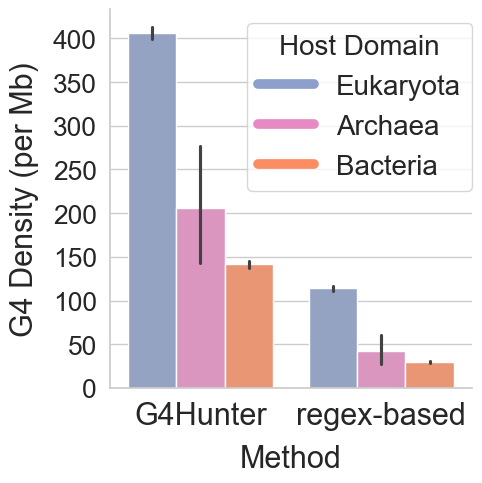

In [17]:
# draw a categorical boxplot to compare G4 densities between  
# viruses with different host domains for g4hunter and regex

sns.set_theme(style="whitegrid")
plt.figure(figsize=(6,6))
sns.catplot(
    data=df_virus_host, 
    kind="bar",
    x="Method", 
    y="G4 Density (per Mb)", 
    hue="Host Domain",
    order=["G4Hunter", "regex-based"],
    hue_order=["Eukaryota", "Archaea", "Bacteria"],
    palette=color_map,
    legend=False,
)
plt.xticks(fontsize=22)
plt.yticks(fontsize=19)
plt.xlabel("Method", fontsize=22, labelpad=10)
plt.ylabel("G4 Density (per Mb)", fontsize=22, labelpad=10)

# create legend
plt.legend(
    title="Host Domain", 
    loc="upper right", 
    fontsize=20,
    title_fontsize=20,
    labels=["Eukaryota", "Archaea", "Bacteria"], 
    bbox_to_anchor=(1.04, 1),
)
# add color patches to legend
legend = plt.gca().get_legend()
handles = legend.get_lines()
handles[0].set_color(color_map["Eukaryota"])
handles[1].set_color(color_map["Archaea"])
handles[2].set_color(color_map["Bacteria"])
for i in range(3):
    handles[i].set_linewidth(7)

plt.tight_layout()
plt.savefig("../plots/virus_host_domain_g4_density.png", dpi=300)

<Figure size 600x600 with 0 Axes>

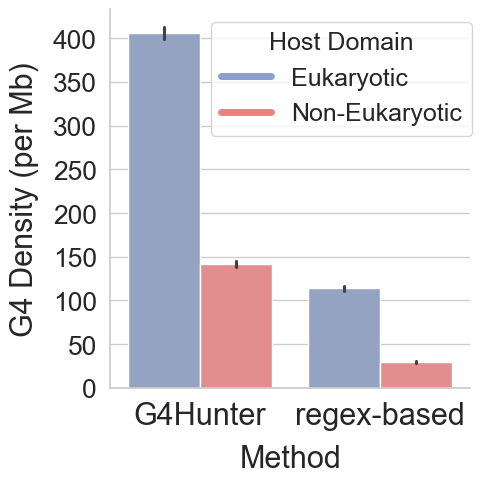

In [9]:
# draw a categorical boxplot to compare G4 densities between  
# viruses with eukaryotic and non-eukaryotic hosts for g4hunter and regex

sns.set_theme(style="whitegrid")
plt.figure(figsize=(6,6))
sns.catplot(
    data=df_virus_host, 
    kind="bar",
    x="Method", 
    y="G4 Density (per Mb)", 
    hue="Euk/Non-Euk Host",
    order=["G4Hunter", "regex-based"],
    hue_order=["Eukaryotic", "Non-Eukaryotic"],
    palette={"Eukaryotic": "#8da0cb", "Non-Eukaryotic": "lightcoral"},
    legend=False,
)
plt.xticks(fontsize=22)
plt.yticks(fontsize=19)
plt.xlabel("Method", fontsize=22, labelpad=10)
plt.ylabel("G4 Density (per Mb)", fontsize=22, labelpad=10)

# create legend
plt.legend(
    title="Host Domain", 
    loc="upper right", 
    labels=["Eukaryotic", "Non-Eukaryotic"], 
    fontsize=18,
    title_fontsize=18,
    bbox_to_anchor=(1.04, 1),
)
# add color patches to legend
legend = plt.gca().get_legend()
handles = legend.get_lines()
handles[0].set_color("#8da0cb")
handles[1].set_color("lightcoral")
for i in range(2):
    handles[i].set_linewidth(5)

plt.tight_layout()
plt.savefig("../plots/virus_host_domain_g4_density_euk.png", dpi=300)

In [10]:
# export figure data
df_virus_host_grouped = df_virus_host.groupby(["Method", "Euk/Non-Euk Host"]).agg({
    "G4 Density (per Mb)": "mean"
}).reset_index()
df_virus_host_grouped.head()
df_virus_host_grouped.rename(columns={
    "Euk/Non-Euk Host": "Host Domain",
}, inplace=True)
df_virus_host_grouped.to_csv("../supplementary_data/virus_host_domain_g4_density.csv", index=False)
df_virus_host_grouped.head()

,Method,Host Domain,G4 Density (per Mb)
0,G4Hunter,Eukaryotic,405.794512
1,G4Hunter,Non-Eukaryotic,141.647660
2,regex-based,Eukaryotic,113.990463
3,regex-based,Non-Eukaryotic,29.487026
